In [1]:
import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib         as mpl
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D
from invisible_cities.io import mcinfo_io as mio
from scipy import stats


In [2]:
def plot_3d_vox(hits_digitized, value='energy', coords = ['x', 'y', 'z'], th=0, edgecolor=None, cmap=mpl.cm.jet):

    xmin, xmax = hits_digitized[coords[0]].min(), hits_digitized[coords[0]].max()
    ymin, ymax = hits_digitized[coords[1]].min(), hits_digitized[coords[1]].max()
    zmin, zmax = hits_digitized[coords[2]].min(), hits_digitized[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([hits_digitized[coords[0]].values-xmin+1, 
                          hits_digitized[coords[1]].values-ymin+1, 
                          hits_digitized[coords[2]].values-zmin+1])
    xarr[tuple(nonzeros)] = hits_digitized[value].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)

    plt.show()

def plot_3d_hits(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())
    
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)

    plt.show()

In [3]:
def read_event(fname, datid, table='Voxels', group='DATASET'):
    with tb.open_file(fname) as h5in:
        return pd.DataFrame.from_records(h5in.root[group][table].read_where('dataset_id==datid'))

## Plotting events from dataset

In [4]:
original_dataset = '/home/mmkekic/MC_dataset/new_data/valid_dataset.h5'
prediction_dataset = '/home/mmkekic/MC_dataset/new_data/tst_file.h5'


In [5]:
dataset_id = 8
original_event = read_event(original_dataset, dataset_id, table='Voxels') 
predicted_event = read_event(prediction_dataset, dataset_id, table='VoxelsPred') 

In [6]:
original_event.head()

,xbin,ybin,zbin,energy,segclass,binclass,dataset_id
0,341,121,529,0.001841,1,1,8
1,340,115,528,0.047246,0,1,8
2,341,112,510,0.010795,1,1,8
3,340,115,527,0.029011,0,1,8
4,341,122,529,0.004580,1,1,8


In [7]:
predicted_event.head()

,label,energy,dataset_id,xbin,ybin,zbin,class_0,class_1,class_2
0,1,0.001841,8,341,121,529,0.082685,0.910976,0.006339
1,0,0.047246,8,340,115,528,0.789265,0.190143,0.020592
2,1,0.010795,8,341,112,510,0.074032,0.913715,0.012252
3,0,0.029011,8,340,115,527,0.530974,0.433397,0.035629
4,1,0.004580,8,341,122,529,0.075187,0.916515,0.008298


In [8]:
#add maxprediction to predicted_event
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1', 'class_2']].values, axis=-1))

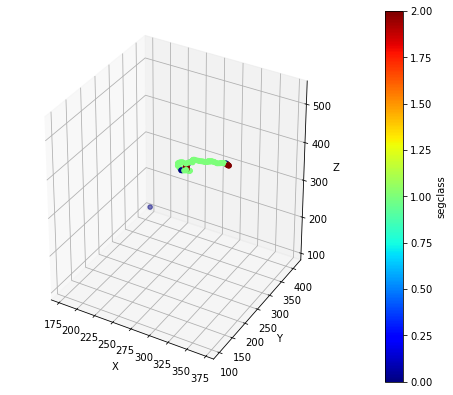

In [9]:
plot_3d_hits(original_event, value='segclass', coords = ['xbin', 'ybin', 'zbin'],  cmap = mpl.cm.jet)

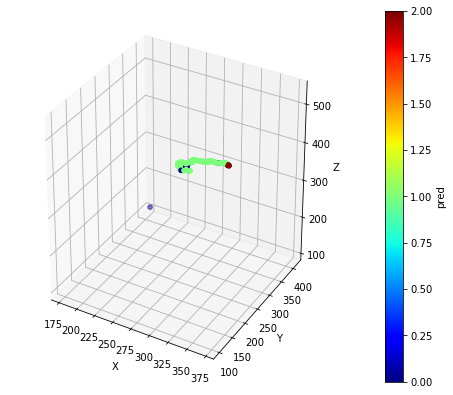

In [10]:
plot_3d_hits(predicted_event, value='pred', coords = ['xbin', 'ybin', 'zbin'])

In [11]:
#for voxel plotting extract the main path volume only

def get_path_volume(df, label):
    dfp = df[df[label]==1][['xbin', 'ybin', 'zbin']]
    xmin, xmax = dfp.xbin.min(), dfp.xbin.max()
    ymin, ymax = dfp.ybin.min(), dfp.ybin.max()
    zmin, zmax = dfp.zbin.min(), dfp.zbin.max()
    volum = df.xbin.between(xmin-5, xmax+5) & df.ybin.between(ymin-5, ymax+5) & df.zbin.between(zmin-5, zmax+5)
    return df[volum]


In [12]:
org_shrinked = get_path_volume(original_event, label='segclass')
pred_shrinked = get_path_volume(predicted_event, label='pred')

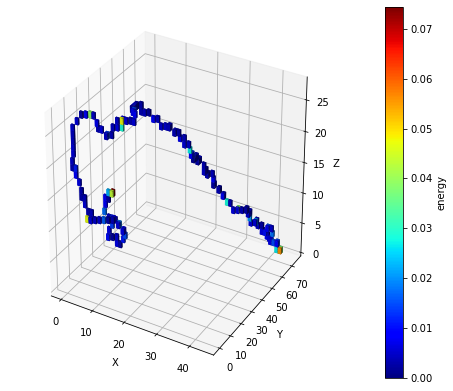

In [13]:
plot_3d_vox(org_shrinked, value='energy', coords = ['xbin', 'ybin', 'zbin'])

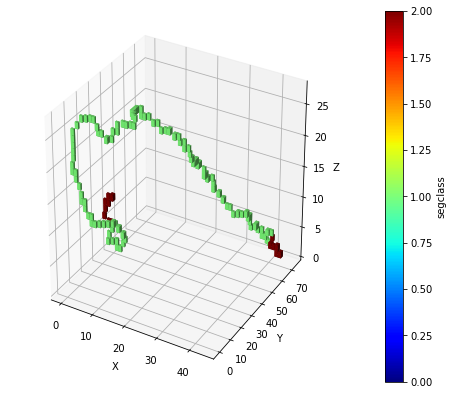

In [16]:
plot_3d_vox(org_shrinked, value='segclass', coords = ['xbin', 'ybin', 'zbin'])

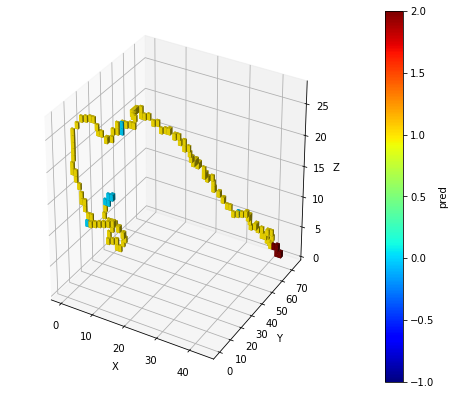

In [14]:
plot_3d_vox(pred_shrinked, value='pred', coords = ['xbin', 'ybin', 'zbin'], th=-1)

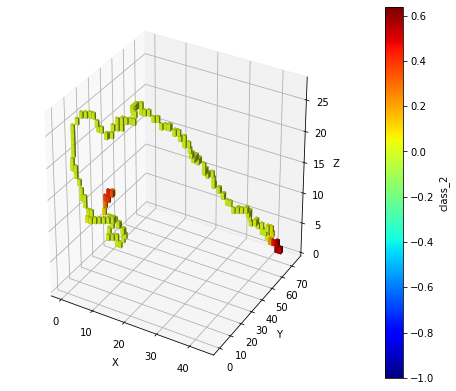

In [15]:
plot_3d_vox(pred_shrinked, value='class_2', coords = ['xbin', 'ybin', 'zbin'], th=-1)